x0 =  6.101404666900635


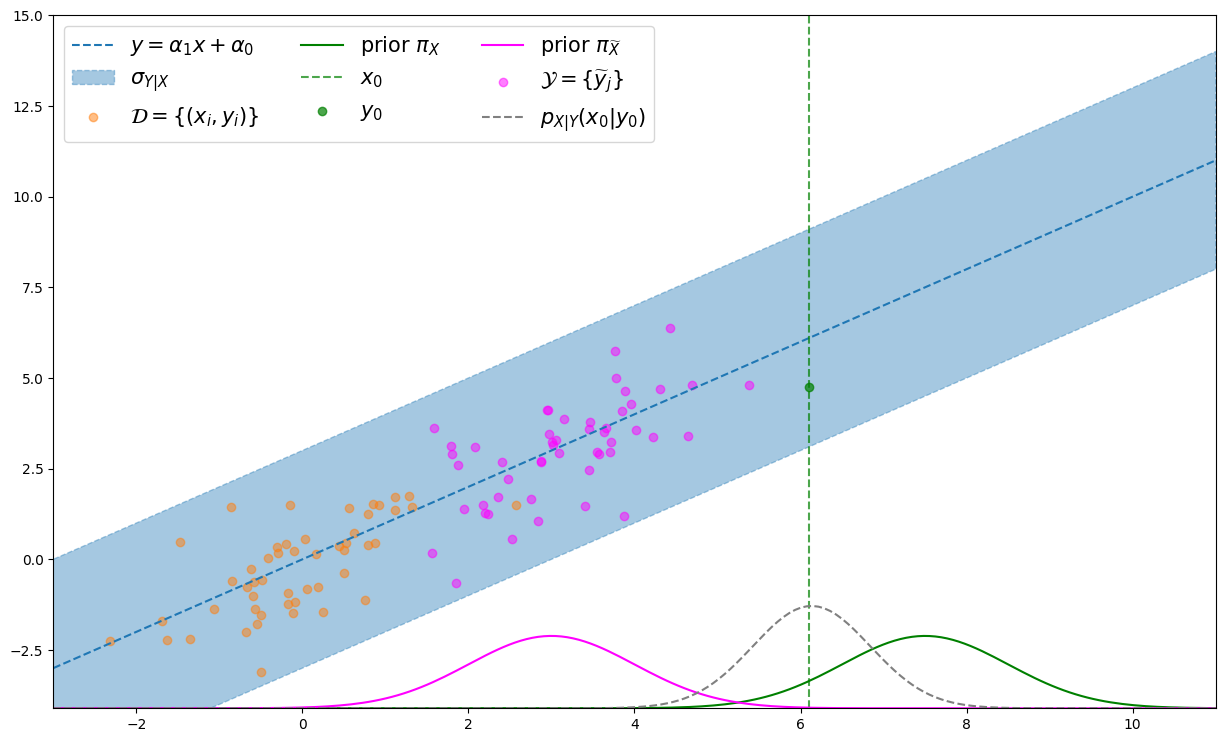

In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from regressor import *
from utils import *
%load_ext autoreload
%autoreload 2
torch.manual_seed(0)

scale_sigma2 = torch.tensor(.5)
shape_sigma2 = torch.tensor(.5)
sigma20 = pyro.distributions.InverseGamma(shape_sigma2, scale_sigma2).sample()
sigma20 = torch.tensor(1)

mu_beta = torch.zeros(2)
Sigma_beta = torch.eye(2)
beta0 =torch.distributions.MultivariateNormal(mu_beta, Sigma_beta).sample()
beta0 = torch.tensor([1.,0.])

mu_X =torch.tensor(7.5)
sigma2_X =torch.tensor(1)
x0 =  torch.distributions.Normal(mu_X, torch.sqrt(sigma2_X)).sample()

prior_dataset = torch.distributions.Normal(torch.tensor(0.), torch.tensor(1))
n_D = 50
DX =prior_dataset.sample([n_D])

sigma2_simulateur = torch.tensor(1)
f = lambda x: beta0[0]*x + beta0[1] 
simulateur= lambda x: f(x) + torch.randn(x.shape[0])*torch.sqrt(sigma20)
DY = simulateur(DX)

print('x0 = ',str(x0.item()))
n_y0= 1
y0 = simulateur(x0.repeat(n_y0))


posterior_mean, posterior_sigma2 =generative_bayesian_linear_regression_known_variance(sigma20,mu_X, sigma2_X).compute_x0_given_y0_beta_moments(y0, torch.tensor(1.))
true_posterior = torch.distributions.Normal(posterior_mean, torch.sqrt(posterior_sigma2))

list_xj = []
list_yj = []
n_unlabeled_obs = 50
n_per_obs = 1
for t in torch.linspace(-10,10,n_unlabeled_obs):
    prior = torch.distributions.Normal(3, 1)
    xj = prior.sample()
    list_xj.append(xj.unsqueeze(0).repeat(n_per_obs))
    yj = simulateur(xj.unsqueeze(0).repeat(n_per_obs))
    list_yj.append(yj.unsqueeze(0))
if n_unlabeled_obs>0:
    Y = torch.cat(list_yj, dim = 0)
    X = torch.cat(list_xj, dim = 0)
else: 
    Y = torch.tensor([])
    X = torch.tensor([])
prior_means = 3*torch.ones(n_unlabeled_obs)
prior_sigma2s = torch.ones(n_unlabeled_obs)

y_min = torch.min(torch.cat([DY, torch.flatten(Y)])-1)

plt.figure(figsize = (15,9))
ax = plt.subplot()
ax.set_xlim(-3,11)
tt = torch.linspace(-3,11,200)
plt.plot(tt.numpy(),f(tt).numpy(), linestyle = '--', label = r'$y = \alpha_1x+ \alpha_0$', color ='C0')
plt.fill_between(tt.numpy(),f(tt).numpy() - 3*torch.sqrt(sigma20).numpy(),f(tt).numpy() + 3*torch.sqrt(sigma20).numpy(),linestyle = '--',color = 'C0',alpha = 0.4, label = r'$\sigma_{Y|X}$')
plt.scatter(DX.numpy(), DY.numpy(), alpha =.5, label = r'$\mathcal{D}=\{(x_i,y_i)\}$', color = 'C1')
plt.plot(tt, y_min + 5*torch.exp(torch.distributions.Normal(mu_X, torch.sqrt(sigma2_X)).log_prob(tt.unsqueeze(-1))), color = 'green', label=r'prior $\pi_X$')
plt.axvline(x0.numpy(), color = 'green', alpha = .7, linestyle = '--', label='$x_0$')
plt.scatter(x0.repeat(n_y0), y0, color = 'green', alpha = .7, label = r'$y_0$')

#hist = plt.hist(y0.numpy(), orientation ='horizontal', bins = n_y0, density = True,histtype = 'step', bottom = -3.5, label = r'histogramme de $y_0$')
plt.plot(tt, y_min + 5*torch.exp(torch.distributions.Normal(3, 1).log_prob(tt.unsqueeze(-1))), color = 'magenta', label=r'prior $\pi_{\widetilde{X}}$')
plt.scatter(X,Y,color = 'magenta', alpha = .5, label = r'$\mathcal{Y} = \{\widetilde{y}_j\}$')
plt.plot(tt,y_min+5*torch.exp(true_posterior.log_prob(tt)),linestyle ='--', label = r'$p_{X|Y}(x_0|y_0)$', color = 'grey')
plt.ylim(y_min,)
plt.legend(ncol = 3, fontsize = 15)
plt.show()

In [2]:
blr = generative_bayesian_affine_regression(mu_X, sigma2_X, mu_beta,Sigma_beta,shape_sigma2, scale_sigma2)
X0_,_,_ = blr.sample_x0_given_y0_D_Y_gibbs(y0, DX, DY,number_steps=100000, verbose = True)
X0,_,_ = blr.sample_x0_given_y0_D_Y_gibbs(y0, DX, DY, Y,prior_means, prior_sigma2s, number_steps=100000, verbose = True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [20:36:57<00:00,  1.35it/s]


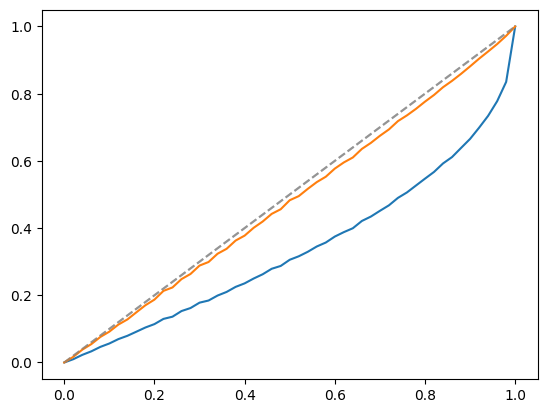

In [3]:
from misc import * 
plt.figure()
plot_expected_coverage_1d_from_density(true_posterior.log_prob,[-20,20], X0_.unsqueeze(-1), show=False)
plot_expected_coverage_1d_from_density(true_posterior.log_prob,[-20,20], X0.unsqueeze(-1), show=False)
plt.show()

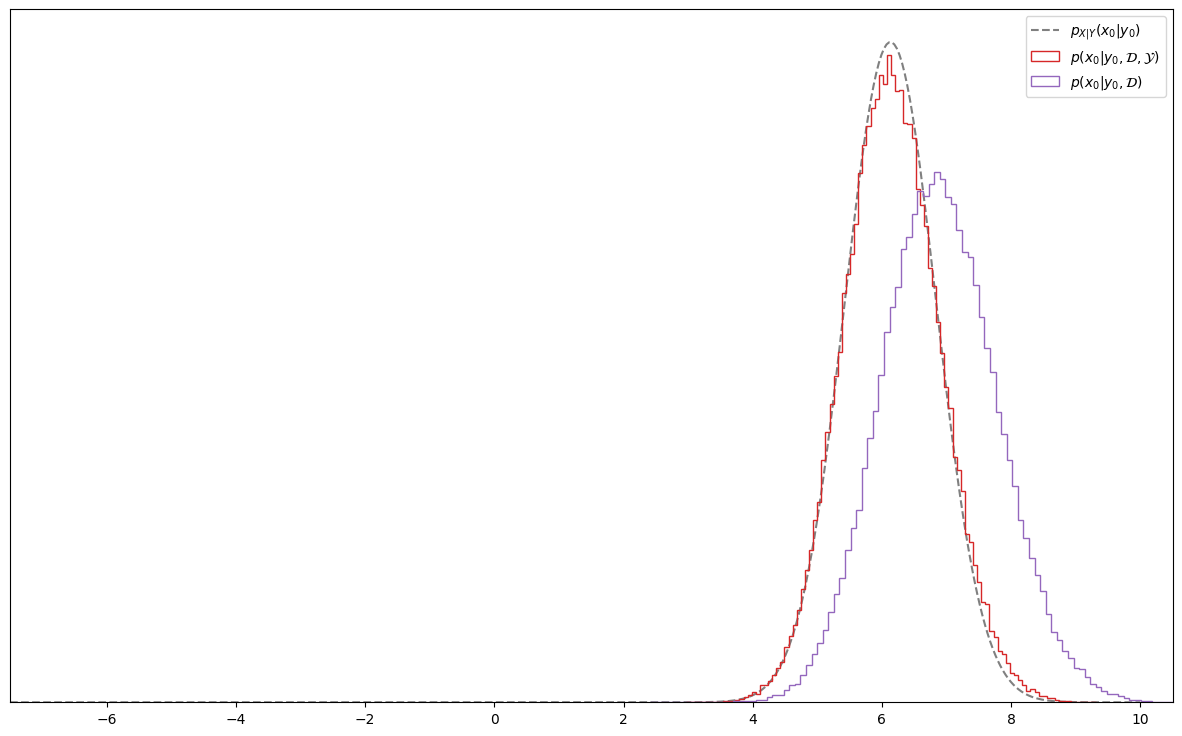

In [4]:
plt.figure(figsize = (15,9))
ax = plt.subplot()
tt_post = torch.linspace(-10,10,500)
plt.plot(tt_post, torch.exp(true_posterior.log_prob(tt_post)),linestyle = '--', label = r'$p_{X|Y}(x_0|y_0)$', color = 'grey')
plt.hist(X0, bins = 100, density = True, histtype = 'step', label = r'$p(x_0|y_0,\mathcal{D},\mathcal{Y})$', color = 'C3')
plt.hist(X0_, bins = 100, density = True, histtype = 'step', label= r'$p(x_0|y_0,\mathcal{D})$', color = 'C4')
ax.tick_params(left=False,bottom=True,labelleft=False,labelbottom=True)
ax.set_xlim(-7.5,10.5)
plt.legend()
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [23:13<00:00, 71.78it/s]


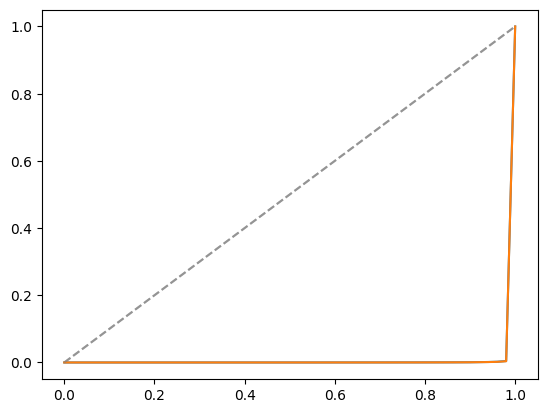

In [5]:
dlbr = discriminative_bayesian_affine_regression(mu_beta, Sigma_beta, shape_sigma2, scale_sigma2)
X0d,_,_ = dlbr.sample_x0_given_y0_D_Y_gibbs(y0, DX, DY, number_steps = 100000, verbose = True)
X0dssl,_,_ = dlbr.sample_x0_given_y0_D_Y_gibbs(y0, DX, DY, Y, number_steps = 100000, verbose = True)
plt.figure()
plot_expected_coverage_1d_from_density(true_posterior.log_prob,[-20,20], X0d.unsqueeze(-1), show=False)
plot_expected_coverage_1d_from_density(true_posterior.log_prob,[-20,20], X0dssl.unsqueeze(-1), show=False)
plt.show()

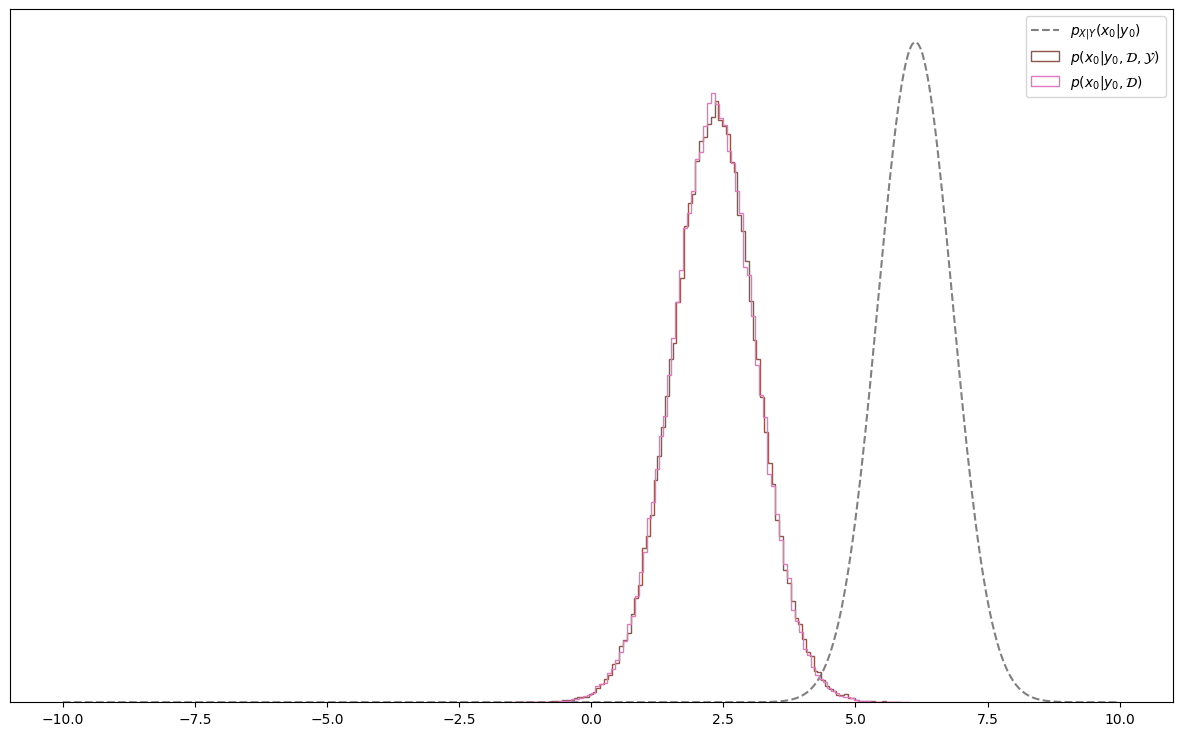

In [6]:
plt.figure(figsize = (15,9))
ax = plt.subplot()
plt.plot(tt_post, torch.exp(true_posterior.log_prob(tt_post)),linestyle = '--', label = r'$p_{X|Y}(x_0|y_0)$', color = 'grey')
plt.hist(X0d, bins = 100, density = True, histtype = 'step', label = r'$p(x_0|y_0,\mathcal{D},\mathcal{Y})$', color = 'C5')
plt.hist(X0dssl, bins = 100, density = True, histtype = 'step', label= r'$p(x_0|y_0,\mathcal{D})$', color = 'C6')
ax.tick_params(left=False,bottom=True,labelleft=False,labelbottom=True)
plt.legend()
plt.show()